#Импорт используемых библиотек

In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

In [55]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [56]:
from catboost import CatBoostClassifier, Pool

#подключение таблиц из датасета

In [57]:
#импорт таблиц из датасета
path = 'train_dataset_soc_dem_train/' # Ваш путь до директории с данными /path/to/data/
data = pd.read_csv(path + 'train_events.csv')
video = pd.read_csv(path + 'video_info_v2.csv')
targets = pd.read_csv(path + 'train_targets.csv')

## просмотр таблиц с данными и информации о таблицах

In [58]:
data.head(2)

,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid
0,2024-06-01 06:40:58+03:00,Chelyabinsk,desktop,browser,Windows,Yandex Browser,1883,video_133074,10067243
1,2024-06-01 19:33:24+03:00,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,512,video_362960,10245341


In [59]:
video.head(2)

,rutube_video_id,title,category,duration,author_id
0,video_185549,Как собрать букет из мыльных тюльпанов - Силик...,Хобби,1559160,1015054
1,video_111035,"Осторожно, Киберземляне!, 1 сезон, 12 серия",Сериалы,1320007,1002180


In [60]:
targets.head(2)

,viewer_uid,age,sex,age_class
0,10087154,30,male,1
1,10908708,25,female,1


In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1759616 entries, 0 to 1759615
Data columns (total 9 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   event_timestamp  object
 1   region           object
 2   ua_device_type   object
 3   ua_client_type   object
 4   ua_os            object
 5   ua_client_name   object
 6   total_watchtime  int64 
 7   rutube_video_id  object
 8   viewer_uid       int64 
dtypes: int64(2), object(7)
memory usage: 120.8+ MB


#Определение функций для отображения результирующих моделей

In [62]:
def get_mode(row): # Кастомная функция вычисления модального значения категориального признака
    counter = Counter(row)
    (most_common, _) = counter.most_common(1)[0]

    return most_common

In [89]:
def validation(model, X_valid, y_valid):
    if model == catc:
        model_valid = model.predict(X_valid)
        model_valid_ = model.predict_proba(X_valid)[:, 1]
    #расчет метрики
    print("f1_weight: ", f1_score(y_valid, model_valid, average='weighted'))
    print("accuracy: ", accuracy_score(y_valid, model_valid))
    print("Отчет о классификации: ")
    print(classification_report(y_valid, model_valid))
    #матрица ошибок
    print("Матрица ошибок: ")
    cm = confusion_matrix(y_valid, model_valid)#, normalize='true'
    cm_display = ConfusionMatrixDisplay(cm).plot(colorbar=False, cmap="GnBu")

    fig, ax = plt.subplots(figsize=(8, 6))
    if model == catc:
        #влияющие факторы
        fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X_valid.columns})
        fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-20:]
        ax.barh(fea_imp['col'], fea_imp['imp'], align='center')

    plt.title('Важность признаков для модели')
    plt.ylabel('Признаки')
    plt.xlabel('Важность')

#Подготовка столбцов (Фич)

##добавление временных фич

In [64]:
#создание маски для перевода времени из МСК в местное
diff_msk = {'Kaliningrad Oblast': -1, 'Kaliningrad': -1,
'Komi':0, 'Karelia':0, 'Arkhangelskaya': 0, 'Arkhangelsk Oblast': 0, 'Nenets':0, 'Vologda Oblast':0, 'Vologda':0,
'St.-Petersburg': 0,  "Leningradskaya Oblast'":0, 'Murmansk':0, 'Novgorod Oblast':0,  'Pskov Oblast':0,
'Moscow': 0, 'Moscow Oblast': 0, 'Belgorod Oblast': 0, 'Bryansk Oblast': 0, 'Vladimir':0,  'Vladimir Oblast': 0,
'Voronezh Oblast':0, 'Voronezj':0,  'Ivanovo Oblast':0, 'Ivanovo':0, 'Kaluga Oblast':0, 'Kaluga':0,
'Kostroma Oblast':0,  'Kursk':0, 'Kursk Oblast': 0, 'Lipetsk Oblast':0, 'Oryol oblast':0, 'Orel Oblast':0,
'Ryazan Oblast': 0, 'Smolensk':0,'Smolenskaya Oblast’':0, 'Smolensk Oblast': 0, 'Tambov': 0, 'Tambov Oblast': 0,
'Tver’ Oblast':0, 'Tver Oblast': 0, 'Tula Oblast':0, 'Tula':0, 'Jaroslavl': 0, 'Yaroslavl Oblast': 0,
'Kirov':0, 'Kirov Oblast': 0, 'Nizhny Novgorod Oblast':0, 'Penza Oblast':0, 'Penza':0, 'Mariy-El Republic': 0,
'Tatarstan Republic': 0, 'Chuvashia': 0, 'Mordoviya Republic':0,
'Adygeya Republic': 0, 'Volgograd Oblast':0, 'Kalmykiya Republic': 0, 'Krasnodarskiy': 0,  'Krasnodar Krai': 0,
'Crimea': 0, 'Rostov': 0, 'Sebastopol City': 0,
'Dagestan': 0, 'Ingushetiya Republic': 0, 'Kabardino-Balkariya Republic': 0, 'Karachayevo-Cherkesiya Republic': 0,
'North Ossetia': 0,  'North Ossetia–Alania': 0, 'Stavropol Kray': 0, 'Stavropol’ Kray': 0, 'Stavropol Krai': 0,
'Chechnya': 0,
'Astrakhan': 1, 'Astrakhan Oblast':1, 'Samara Oblast': 1, 'Saratov Oblast': 1,  'Saratovskaya Oblast': 1,
'Ulyanovsk': 1, 'Udmurtiya Republic': 1,
'Chelyabinsk': 2, 'Bashkortostan Republic': 2, 'Perm Krai': 2, 'Perm': 2, 'Kurgan Oblast': 2,
'Sverdlovsk': 2, 'Sverdlovsk Oblast': 2, 'Tyumen Oblast': 2, 'Tyumen’ Oblast': 2, 'Orenburg Oblast': 2,
'Yamalo-Nenets': 2, 'Khanty-Mansia': 2,
'Omsk Oblast': 3,  'Omsk': 3,
'Altay Kray': 4, 'Altai': 4, 'Krasnoyarsk Krai': 4, 'Krasnoyarskiy': 4,  'Novosibirsk Oblast': 4,
'Kuzbass':4, 'Kemerovo Oblast': 4, 'Khakasiya Republic': 4, 'Tyva Republic': 4, 'Tomsk Oblast': 4,
'Irkutsk Oblast': 5, 'Transbaikal Territory':5, 'Zabaykalskiy (Transbaikal) Kray': 5, 'Buryatiya Republic':5,
'Amur Oblast': 6, 'Sakha': 6,
'Primorye': 7, 'Primorskiy (Maritime) Kray': 7, 'Jewish Autonomous Oblast': 7, 'Khabarovsk': 7,
'Sakhalin Oblast': 8,  'Magadan Oblast': 8,
'Kamchatka': 9, 'Chukotka': 9, }

In [65]:
#время к местному
data['event_timestamp']=pd.to_datetime(data['event_timestamp'])
data['diff_msk']=data['region'].map(diff_msk)
data['diff_msk']=pd.to_timedelta(data['diff_msk'], unit='hours')
data['timestamp']=data['event_timestamp'].dt.tz_localize(None)+data['diff_msk']

#день недели -> понедельник 1... вск 7
data['weekday'] = data['timestamp'].dt.weekday + 1
data['hour'] = data['timestamp'].dt.hour

In [66]:
data.head(2)

,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid,diff_msk,timestamp,weekday,hour
0,2024-06-01 06:40:58+03:00,Chelyabinsk,desktop,browser,Windows,Yandex Browser,1883,video_133074,10067243,0 days 02:00:00,2024-06-01 08:40:58,6,8
1,2024-06-01 19:33:24+03:00,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,512,video_362960,10245341,0 days 02:00:00,2024-06-01 21:33:24,6,21


In [67]:
# создаем фиктивные столбцы для всех значений weekday и hour
data_time = pd.get_dummies(data[['weekday', 'hour', 'viewer_uid']],
                           columns=['weekday', 'hour']).groupby('viewer_uid', as_index=False).sum() #суммируем активность каждого пользователя в опред. час и опред. день недели
data_time.head(2)

,viewer_uid,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,hour_0,hour_1,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,10000001,2,3,1,2,2,7,2,1,0,...,1,0,1,0,0,1,4,4,4,1
1,10000002,0,0,0,0,6,1,2,1,0,...,2,0,0,0,0,1,3,1,0,1


##добавление фич - основных характеристик пользователей

In [68]:
data_user = data.groupby('viewer_uid', as_index=False).agg(
    watching=('viewer_uid', 'count'),   #считаем кол-во просмотренных видео за всё время
    region=('region', get_mode),        #вычисляем наиболее частовстречающийся регион пользователя (домашний)
    device_type=('ua_device_type', get_mode), #вычисляем целевое устройство пользователя
    client_type=('ua_client_type', get_mode), #Вычисляем тип приложения, с которого пользователь заходит на сайт чаще всего
    os=('ua_os', get_mode), #вычисляем целевую ОС
    client_name=('ua_client_name', get_mode), #Вычисляем браузер/приложение пользователя
)

In [69]:
data_user.head(2)

,viewer_uid,watching,region,device_type,client_type,os,client_name
0,10000001,19,Moscow,desktop,browser,Windows,Chrome
1,10000002,9,Moscow,tablet,mobile app,Android,Rutube


##добавление фич - харакетристик видео

In [70]:
merged_df = pd.merge(data[['total_watchtime', 'rutube_video_id', 'viewer_uid']], video, on=['rutube_video_id']) #объединяем таблицу data (лишь с некоторыми столбцами) и video по video_id
merged_df['duration']=merged_df['duration']/1000 #в секунды
merged_df['watch_part']=(100*merged_df['total_watchtime']/merged_df['duration']).round(1) #процент просмотра
merged_df.head(2)

,total_watchtime,rutube_video_id,viewer_uid,title,category,duration,author_id,watch_part
0,1883,video_133074,10067243,Папа с особенностями. Мужское / Женское. Выпус...,Телепередачи,2456.534,1009219,76.7
1,830,video_133074,10050175,Папа с особенностями. Мужское / Женское. Выпус...,Телепередачи,2456.534,1009219,33.8


In [71]:
merged_video = merged_df.groupby('viewer_uid', as_index=False).agg(
    video_count=('rutube_video_id', 'count'), #кол-во просмотренных видео
    video_unique=('rutube_video_id', 'nunique'), #кол-во уникальных видео
    watch_min=('total_watchtime', 'min'),     #метрики времени просмотра видео каждого пользователя
    watch_max=('total_watchtime', 'max'),
    watch_median=('total_watchtime', 'median'),
    watch_mean=('total_watchtime', 'mean'),
    part_min=('watch_part', 'min'),           #метрики времени просмотра видео каждого пользователя, в процентах
    part_max=('watch_part', 'max'),
    part_median=('watch_part', 'median'),
    part_mean=('watch_part', 'mean'),
    category=('category', get_mode),          #целевая категория видео для пользователя (какую категорию он смотрит чаще)
    author_id=('author_id', get_mode),        #любимый автор пользователя
).round(1)

merged_video.head(2)

,viewer_uid,video_count,video_unique,watch_min,watch_max,watch_median,watch_mean,part_min,part_max,part_median,part_mean,category,author_id
0,10000001,19,16,562,6932,4003.0,3618.8,11.8,157.7,86.3,74.7,Телепередачи,1009257
1,10000002,9,9,80,6688,1210.0,1691.1,1.0,100.0,99.5,84.6,Сериалы,1065557


In [72]:
data_video = pd.get_dummies(merged_df[['category', 'viewer_uid']], columns=['category',]).groupby('viewer_uid', as_index=False).sum() #добавляем фиктивные столбцы для каждой категории и считаем кол-во просмотров в каждой категории

In [73]:
data_video.head(2)

,viewer_uid,category_Авто-мото,category_Аниме,category_Аудио,category_Аудиокниги,category_Бизнес и предпринимательство,category_Видеоигры,category_Детям,category_Дизайн,category_Еда,...,category_Сериалы,category_Спорт,category_Строительство и ремонт,category_Телепередачи,category_Техника и оборудование,category_Технологии и интернет,category_Фильмы,category_Хобби,category_Эзотерика,category_Юмор
0,10000001,0,0,0,0,0,0,0,0,0,...,0,0,0,19,0,0,0,0,0,0
1,10000002,0,0,0,0,0,0,0,0,0,...,7,0,0,0,0,0,1,0,0,0


In [74]:
#объединяем все таблицы в одну, по ID пользователя
all_df = pd.merge(data_time, data_user, on=['viewer_uid'])
all_df = pd.merge(all_df, merged_video, on=['viewer_uid'])
all_df = pd.merge(all_df, data_video, on=['viewer_uid'])
all_df = pd.merge(all_df, targets, on=['viewer_uid'])
#заполнение пропусков
all_df['os']=all_df['os'].fillna("_")
all_df.head(2)

,viewer_uid,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,hour_0,hour_1,...,category_Телепередачи,category_Техника и оборудование,category_Технологии и интернет,category_Фильмы,category_Хобби,category_Эзотерика,category_Юмор,age,sex,age_class
0,10000001,2,3,1,2,2,7,2,1,0,...,19,0,0,0,0,0,0,40,female,2
1,10000002,0,0,0,0,6,1,2,1,0,...,0,0,0,1,0,0,0,44,male,3


##разделение фич на группы

In [75]:
#числовые колонки
num_col = ['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4','weekday_5', 'weekday_6', 'weekday_7', 'hour_0',
           'hour_1', 'hour_2','hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
           'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
           'hour_20', 'hour_21', 'hour_22', 'hour_23', 'watching', 'video_unique', 'watch_min', 'watch_max',
           'watch_median', 'watch_mean', 'part_min', 'part_max', 'part_median', 'part_mean',
           'category_Авто-мото', 'category_Аниме', 'category_Аудио', 'category_Аудиокниги',
           'category_Бизнес и предпринимательство', 'category_Видеоигры', 'category_Детям', 'category_Дизайн',
           'category_Еда', 'category_Животные', 'category_Здоровье',
           'category_Интервью', 'category_Красота', 'category_Культура',
           'category_Лайфстайл', 'category_Лайфхаки', 'category_Люди и блоги',
           'category_Музыка', 'category_Мультфильмы', 'category_Наука',
           'category_Недвижимость', 'category_Обзоры и распаковки товаров',
           'category_Обучение', 'category_Охота и рыбалка', 'category_Природа',
           'category_Психология', 'category_Путешествия', 'category_Развлечения',
           'category_Разное', 'category_Сад и огород', 'category_Сериалы',
           'category_Спорт', 'category_Строительство и ремонт',
           'category_Телепередачи', 'category_Техника и оборудование',
           'category_Технологии и интернет', 'category_Фильмы', 'category_Хобби',
           'category_Эзотерика', 'category_Юмор',]
#категориальные колонки
cat_col = ['region', 'device_type', 'client_type', 'os', 'client_name', 'category', 'author_id']
#target-колонки
targets_col = ['viewer_uid', 'age', 'sex', 'age_class']

#Обучение моделей

### Разделение на выборки

In [76]:
#Разделяем пользователей по количеству просмотров, чтобы дополнительно провести исследование оценки качества модели в зависимости от количества просмотров пользователя
#n - число просмотров-разделитель
n = 2
HOLD_IDS = all_df[all_df['watching']<=n]['viewer_uid'].unique()
ALL_IDS = all_df[all_df['watching']>n]['viewer_uid'].unique()

In [77]:
#Делим на обучающую и валидационную выборки
TRAIN_IDS, VAL_IDS = train_test_split(ALL_IDS, train_size=0.8, shuffle=True, random_state=11)

In [79]:
print("Длина выборок: ", len(TRAIN_IDS), len(VAL_IDS), len(HOLD_IDS))

Длина выборок:  95466 23867 60679


In [80]:
train_events = all_df[all_df['viewer_uid'].isin(TRAIN_IDS)] #группируем события для тех пользователей, которые есть в тренировочной выборке
val_events = all_df[all_df['viewer_uid'].isin(VAL_IDS)]     #группируем события для тех пользователей, которые есть в валидационной выборке
hold_events = all_df[all_df['viewer_uid'].isin(HOLD_IDS)]   #группируем события для тех пользователей, чьи сумм. просмотры <3

In [81]:
#создаем датафреймы со всеми фичами для всех выборок
X_train_part = train_events[num_col+cat_col]
X_valid = val_events[num_col+cat_col]
X_hold = hold_events[num_col+cat_col]

##предсказание пола

In [ ]:
#создаем датафреймы с целевым столбцом пола
y_train_part = train_events['sex']
y_valid = val_events['sex']
y_hold = hold_events['sex']

In [ ]:
#создаем предсказательную модель и обучаем её
catc = CatBoostClassifier(loss_function = "Logloss",
                          eval_metric="F1",
                          learning_rate=0.1,
                          max_depth = 16,
                          n_estimators = 2000,
                          auto_class_weights='Balanced',
                          leaf_estimation_iterations=1, random_state=42, task_type='CPU')
catc.fit(X_train_part, y_train_part, eval_set=(X_valid, y_valid), cat_features=cat_col,
         early_stopping_rounds = 100, use_best_model=True, verbose=500)

0:	learn: 0.7398344	test: 0.7137996	best: 0.7137996 (0)	total: 10.4s	remaining: 5h 45m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7674877961
bestIteration = 87

Shrink model to first 88 iterations.


In [ ]:
#```сохраним модель
catc.save_model('model_sex.cbm')
#для загрузки использовать
#catc.load_model('model_sex.cbm')```

f1_weight:  0.7614785082523863
accuracy:  0.7610927221686848
Отчет о классификации: 
              precision    recall  f1-score   support

      female       0.80      0.74      0.77     12894
        male       0.72      0.78      0.75     10973

    accuracy                           0.76     23867
   macro avg       0.76      0.76      0.76     23867
weighted avg       0.76      0.76      0.76     23867

Матрица ошибок: 


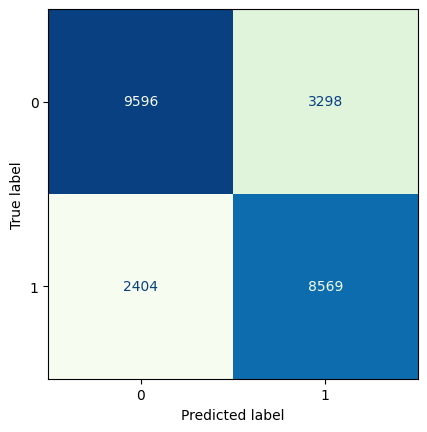

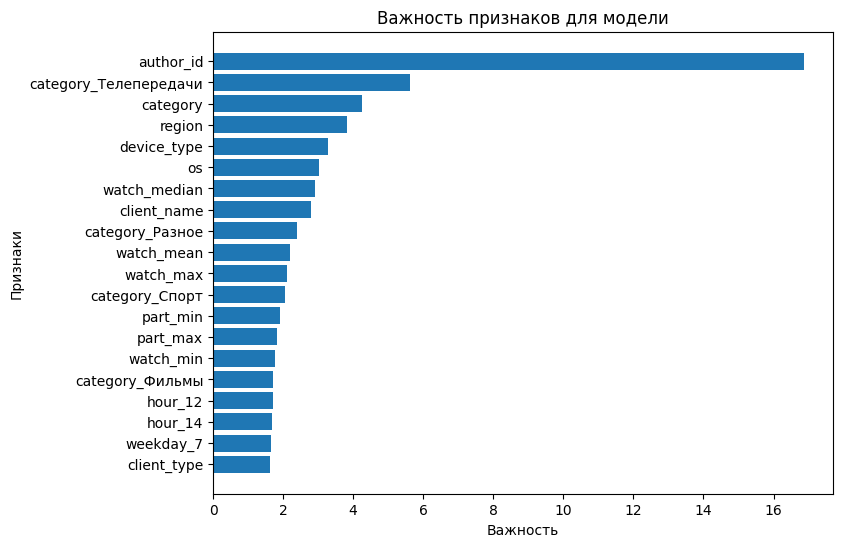

In [ ]:
#запуск модели для валидационных данных
validation(catc, X_valid, y_valid)

f1_weight:  0.6873682522483092
accuracy:  0.7015606717315711
Отчет о классификации: 
              precision    recall  f1-score   support

      female       0.72      0.47      0.57     25471
        male       0.69      0.87      0.77     35208

    accuracy                           0.70     60679
   macro avg       0.71      0.67      0.67     60679
weighted avg       0.70      0.70      0.69     60679

Матрица ошибок: 


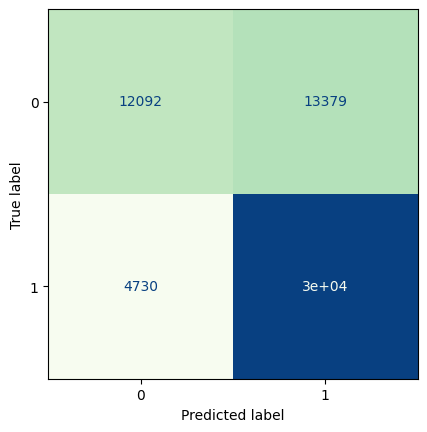

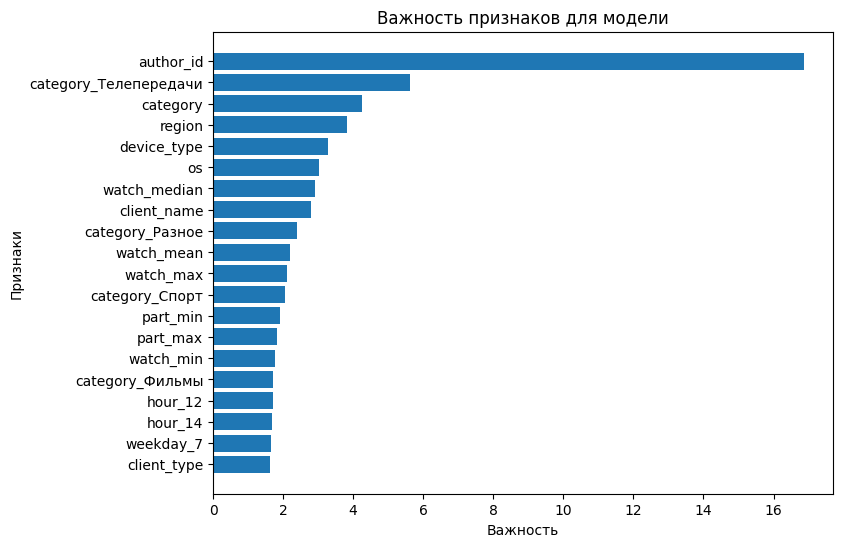

In [ ]:
validation(catc, X_hold, y_hold)

##Предсказание возраста

In [82]:
y_train_part = train_events['age_class']
y_valid = val_events['age_class']
y_hold = hold_events['age_class']

In [84]:
catc = CatBoostClassifier(loss_function = "MultiClass", #CrossEntropy "Logloss"
                          eval_metric="AUC",  #eval_metric="F1","AUC",Precision Recall BalancedAccuracy
                          learning_rate=0.1,
                          max_depth = 4,
                          n_estimators = 2000,
                          auto_class_weights='Balanced',
                          l2_leaf_reg = 1.5,
                          leaf_estimation_iterations=1, random_state=42, task_type='CPU')
catc.fit(X_train_part, y_train_part, eval_set=(X_valid, y_valid), cat_features=cat_col,
         early_stopping_rounds = 100, use_best_model=True, verbose=500)

0:	test: 0.5959992	best: 0.5959992 (0)	total: 1.35s	remaining: 45m 4s
500:	test: 0.7491983	best: 0.7491983 (500)	total: 6m 13s	remaining: 18m 38s
1000:	test: 0.7519668	best: 0.7519676 (999)	total: 12m 33s	remaining: 12m 31s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7520281563
bestIteration = 1013

Shrink model to first 1014 iterations.


In [85]:
#```сохраним модель
catc_.save_model('model_age.cbm')
#для загрузки использовать
#catc.load_model('model_age.cbm')```

f1_weight:  0.3982375138918909
accuracy:  0.38329073616290277
Отчет о классификации: 
              precision    recall  f1-score   support

           0       0.09      0.53      0.16       975
           1       0.52      0.37      0.43      8876
           2       0.45      0.25      0.32      8687
           3       0.45      0.60      0.51      5329

    accuracy                           0.38     23867
   macro avg       0.38      0.44      0.36     23867
weighted avg       0.46      0.38      0.40     23867

Матрица ошибок: 


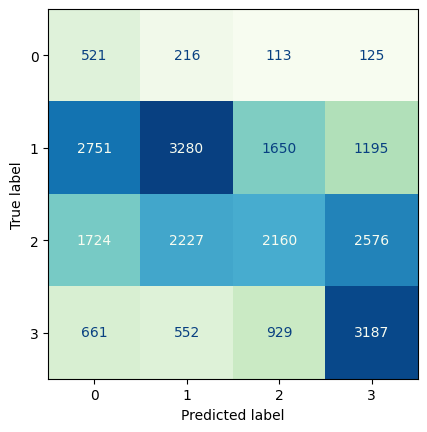

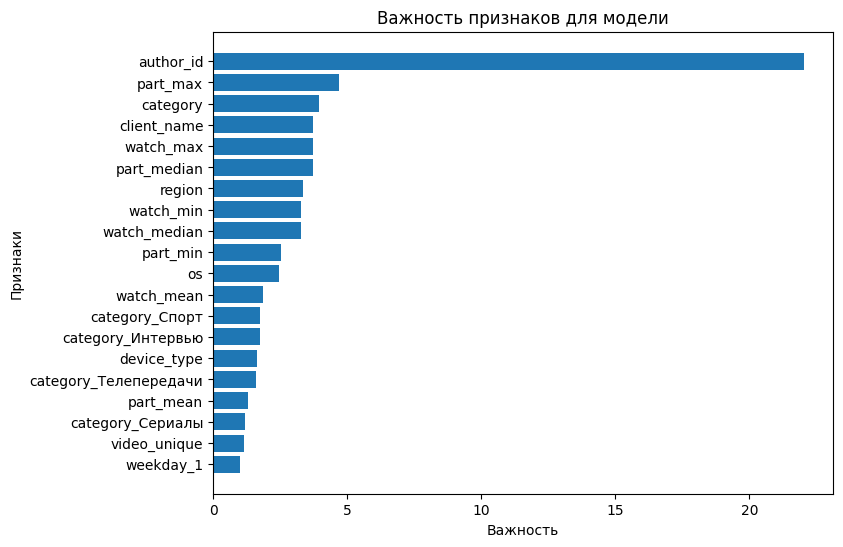

In [90]:
validation(catc, X_valid, y_valid)

f1_weight:  0.32007611883986115
accuracy:  0.313716442261738
Отчет о классификации: 
              precision    recall  f1-score   support

           0       0.07      0.53      0.12      2632
           1       0.47      0.25      0.32     18847
           2       0.44      0.14      0.21     21735
           3       0.42      0.58      0.49     17465

    accuracy                           0.31     60679
   macro avg       0.35      0.37      0.28     60679
weighted avg       0.43      0.31      0.32     60679

Матрица ошибок: 


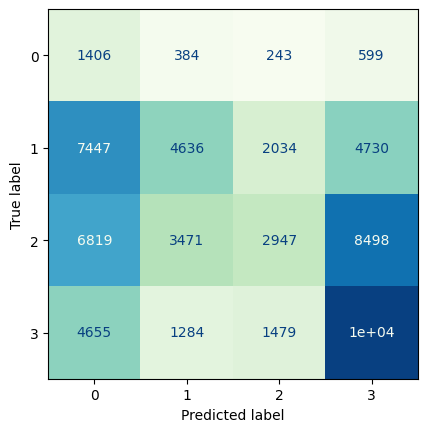

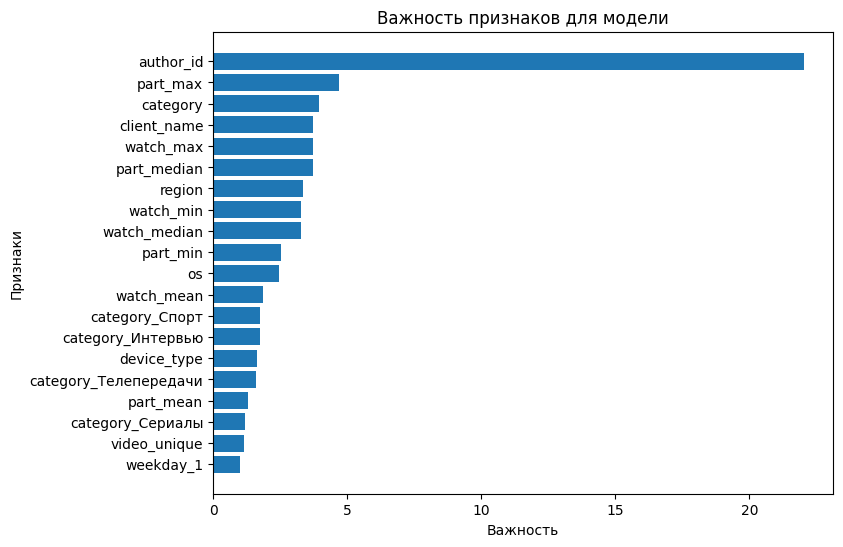

In [91]:
validation(catc, X_hold, y_hold)